# ***Environment Setup and Dataset Preparation***

We'll set up:

Reproducibility (seeds, deterministic behavior)

Load MNIST dataset

Split into 60% train, 20% val, 20% test

Create DataLoaders

In [1]:
# 🔧 Basic Setup: Libraries and Seed Fixing
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random

# 📌 Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# 💻 Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🖼️ Transform and Load MNIST
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 🔀 Split: 60% train, 20% val, 20% test
train_size = int(0.6 * len(mnist_data))
val_size = int(0.2 * len(mnist_data))
test_size = len(mnist_data) - train_size - val_size

train_data, val_data, test_data = random_split(mnist_data, [train_size, val_size, test_size])

# 📦 DataLoaders
def get_loader(dataset, batch_size=64):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_loader(train_data)
val_loader = get_loader(val_data)
test_loader = get_loader(test_data)

print(f"Train size: {len(train_data)} | Val size: {len(val_data)} | Test size: {len(test_data)}")


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]

Train size: 36000 | Val size: 12000 | Test size: 12000


# ***Find the best learning rate for a simple CNN on MNIST using SGD with Momentum***

🏗️ Model Architecture
A minimal CNN:

2 convolutional layers

1 fully connected layer

No batch norm or pooling

ReLU activation

In [3]:
# 🧠 Simple CNN: 2 Conv + 1 FC (No BN, No Pooling)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 10)
        )

    def forward(self, x):
        return self.net(x)

# 🔁 Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    model = model.to(device)
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Validation Accuracy: {val_acc:.4f}")

    return model, val_accuracies



Training with learning rate: 1
Epoch 1/50 - Validation Accuracy: 0.0966
Epoch 2/50 - Validation Accuracy: 0.1132
Epoch 3/50 - Validation Accuracy: 0.1001
Epoch 4/50 - Validation Accuracy: 0.1041
Epoch 5/50 - Validation Accuracy: 0.0926
Epoch 6/50 - Validation Accuracy: 0.1070
Epoch 7/50 - Validation Accuracy: 0.0926
Epoch 8/50 - Validation Accuracy: 0.1041
Epoch 9/50 - Validation Accuracy: 0.0888
Epoch 10/50 - Validation Accuracy: 0.1070
Epoch 11/50 - Validation Accuracy: 0.1132
Epoch 12/50 - Validation Accuracy: 0.0972
Epoch 13/50 - Validation Accuracy: 0.0972
Epoch 14/50 - Validation Accuracy: 0.1070
Epoch 15/50 - Validation Accuracy: 0.1132
Epoch 16/50 - Validation Accuracy: 0.1132
Epoch 17/50 - Validation Accuracy: 0.1132
Epoch 18/50 - Validation Accuracy: 0.0926
Epoch 19/50 - Validation Accuracy: 0.1132
Epoch 20/50 - Validation Accuracy: 0.0888
Epoch 21/50 - Validation Accuracy: 0.0926
Epoch 22/50 - Validation Accuracy: 0.1005
Epoch 23/50 - Validation Accuracy: 0.1041
Epoch 24/50

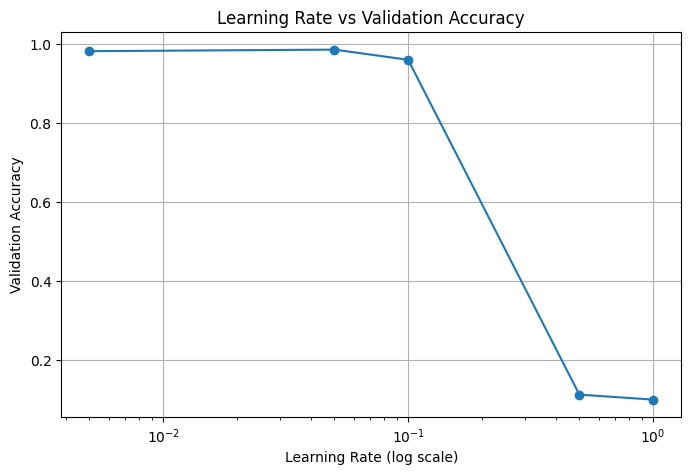

In [4]:
# 🎯 Learning Rates to try
learning_rates = [1, 0.5, 0.1, 0.05, 0.005]
final_val_accuracies = []

# 🧪 Try each learning rate
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = SimpleCNN()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    _, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50)
    final_val_acc = val_accuracies[-1]
    final_val_accuracies.append(final_val_acc)
    print(f"Final Validation Accuracy for LR={lr}: {final_val_acc:.4f}")

# 📊 Plot: Learning Rate vs Final Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, final_val_accuracies, marker='o')
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Learning Rate vs Validation Accuracy")
plt.grid(True)
plt.show()


# ***Investigate the Effect of Depth (Sigmoid-only Network)***

Train fully connected networks of increasing depth (3, 5, 10, 20, 50 layers) using only sigmoid activations (⚠️ no ReLU, no batch norm), and observe how validation accuracy changes.



In [8]:
# Transform: flatten and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 → 784
])

# Download dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

# Split training into train/val
train_data, val_data = random_split(train_dataset, [50000, 10000])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64)


In [9]:
class SigmoidMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Sigmoid()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [13]:
def train_model(model, train_loader, val_loader, lr=0.05, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"Epoch {epoch}/{epochs} - Validation Accuracy: {val_acc:.4f}")

    return val_acc  # 🔁 This line is what was missing!


In [14]:
layer_list = [3, 5, 10, 20, 50]
results = {}

for num_layers in layer_list:
    print(f"\nTraining model with {num_layers} hidden layers...")
    model = SigmoidMLP(input_dim=784, hidden_dim=128, output_dim=10, num_layers=num_layers)
    acc = train_model(model, train_loader, val_loader, lr=0.05, epochs=50)
    results[num_layers] = acc
    print(f"Final validation accuracy for {num_layers} layers: {acc:.4f}")



Training model with 3 hidden layers...
Epoch 1/50 - Validation Accuracy: 0.1199
Epoch 2/50 - Validation Accuracy: 0.0961
Epoch 3/50 - Validation Accuracy: 0.0972
Epoch 4/50 - Validation Accuracy: 0.0968
Epoch 5/50 - Validation Accuracy: 0.1199
Epoch 6/50 - Validation Accuracy: 0.0968
Epoch 7/50 - Validation Accuracy: 0.2238
Epoch 8/50 - Validation Accuracy: 0.3446
Epoch 9/50 - Validation Accuracy: 0.5064
Epoch 10/50 - Validation Accuracy: 0.6083
Epoch 11/50 - Validation Accuracy: 0.7000
Epoch 12/50 - Validation Accuracy: 0.7942
Epoch 13/50 - Validation Accuracy: 0.8259
Epoch 14/50 - Validation Accuracy: 0.8367
Epoch 15/50 - Validation Accuracy: 0.8549
Epoch 16/50 - Validation Accuracy: 0.8714
Epoch 17/50 - Validation Accuracy: 0.8730
Epoch 18/50 - Validation Accuracy: 0.8846
Epoch 19/50 - Validation Accuracy: 0.8897
Epoch 20/50 - Validation Accuracy: 0.8715
Epoch 21/50 - Validation Accuracy: 0.9006
Epoch 22/50 - Validation Accuracy: 0.9062
Epoch 23/50 - Validation Accuracy: 0.9089
Epo

Text(0.5, 1.0, 'Validation Accuracy vs. Number of Hidden Layers')

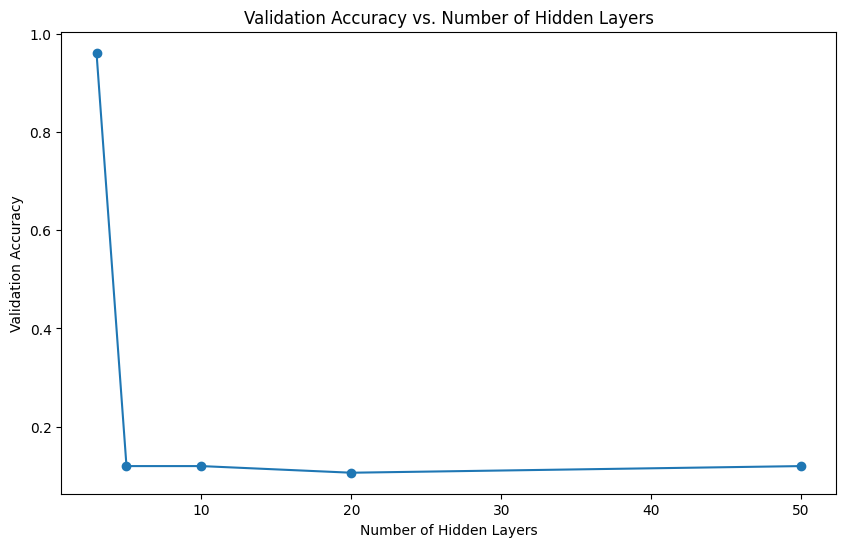

In [15]:
#plot:
plt.figure(figsize=(10, 6))
plt.plot(results.keys(), results.values(), marker='o')
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Number of Hidden Layers")

# ***BatchNorm + LeakyReLU***

🔧 Step-by-Step Plan
Define the model builder for a variable number of Conv → BatchNorm → LeakyReLU layers

Training + validation loop with logging

Automatically adjust epochs based on depth (e.g. 10 for 40 layers)

Save model + accuracy after each run

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, depth, in_channels=1, base_filters=16, num_classes=10):
        super(DeepCNN, self).__init__()
        layers = []
        channels = in_channels

        for _ in range(depth):
            layers.append(nn.Conv2d(channels, base_filters, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(base_filters))
            layers.append(nn.LeakyReLU(0.01))
            channels = base_filters

        self.conv_layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_filters, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [17]:
import torch.optim as optim
from tqdm import tqdm
import os

def train_and_evaluate(depth, train_loader, val_loader, device, base_lr, max_epochs, save_path=None):
    model = DeepCNN(depth).to(device)
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        best_val_acc = max(best_val_acc, val_acc)

        print(f"[Depth {depth}] Epoch {epoch+1}/{max_epochs} - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save model and best val acc
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_acc': best_val_acc
        }, save_path)

    return best_val_acc


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set random seed
import torch
torch.manual_seed(42)

# Transform: ensure [1, 28, 28] shape
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [C x H x W] in range [0.0, 1.0]
])

# Download and load MNIST
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split: 60% train, 20% val, 20% test of the 60k samples
train_size = int(0.6 * len(full_dataset))   # 36,000
val_size = int(0.2 * len(full_dataset))     # 12,000
test_size = len(full_dataset) - train_size - val_size  # 12,000

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# --- Define EarlyStopping Class ---
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

# --- CNN Model Generator ---
def build_cnn(depth, input_channels=1):
    layers = []
    channels = input_channels
    for _ in range(depth):
        layers.append(nn.Conv2d(channels, 16, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(16))  # Include BatchNorm
        layers.append(nn.LeakyReLU(inplace=True))  # LeakyReLU
        channels = 16
    model = nn.Sequential(
        *layers,
        nn.Flatten(),
        nn.Linear(16 * 28 * 28, 10)  # MNIST is 28x28
    )
    return model

# --- Train + Evaluate Function ---
def train_and_evaluate(depth, train_loader, val_loader, device, base_lr, max_epochs, save_path):
    model = build_cnn(depth).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)

    early_stopper = EarlyStopping(patience=3)

    for epoch in range(max_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        print(f"Epoch {epoch+1}/{max_epochs} - Val Accuracy: {val_acc:.4f}")

        early_stopper(val_acc)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    torch.save(model.state_dict(), save_path)
    return val_acc


In [26]:
depths = [4, 8, 16, 20, 30, 40]
epoch_map = {
    4: 50,
    8: 50,
    16: 50,
    20: 30,
    30: 15,
    40: 10
}

results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_lr = 0.05  # From Task 1

for depth in depths:
    print(f"\nTraining model with {depth} layers...")
    val_acc = train_and_evaluate(
        depth=depth,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        base_lr=best_lr,
        max_epochs=epoch_map[depth],
        save_path=f"/content/drive/MyDrive/mnist_deepcnn/depth{depth}.pt"
    )
    results[depth] = val_acc



Training model with 4 layers...
Epoch 1/50 - Val Accuracy: 0.9343
Epoch 2/50 - Val Accuracy: 0.9583
Epoch 3/50 - Val Accuracy: 0.9617
Epoch 4/50 - Val Accuracy: 0.9663
Epoch 5/50 - Val Accuracy: 0.9698
Epoch 6/50 - Val Accuracy: 0.9698
Epoch 7/50 - Val Accuracy: 0.9682
Epoch 8/50 - Val Accuracy: 0.9709
Epoch 9/50 - Val Accuracy: 0.9692
Epoch 10/50 - Val Accuracy: 0.9710
Epoch 11/50 - Val Accuracy: 0.9666
Early stopping triggered.

Training model with 8 layers...
Epoch 1/50 - Val Accuracy: 0.9553
Epoch 2/50 - Val Accuracy: 0.9606
Epoch 3/50 - Val Accuracy: 0.9653
Epoch 4/50 - Val Accuracy: 0.9445
Epoch 5/50 - Val Accuracy: 0.9797
Epoch 6/50 - Val Accuracy: 0.9794
Epoch 7/50 - Val Accuracy: 0.9724
Epoch 8/50 - Val Accuracy: 0.9819
Epoch 9/50 - Val Accuracy: 0.9827
Epoch 10/50 - Val Accuracy: 0.9685
Epoch 11/50 - Val Accuracy: 0.9800
Early stopping triggered.

Training model with 16 layers...
Epoch 1/50 - Val Accuracy: 0.8636
Epoch 2/50 - Val Accuracy: 0.9590
Epoch 3/50 - Val Accuracy: 0

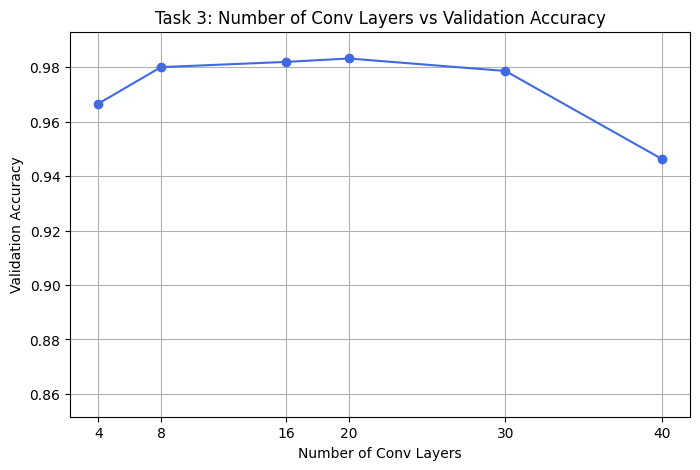

In [27]:
import matplotlib.pyplot as plt

# Extract x and y values from results dictionary
x = list(results.keys())
y = list(results.values())

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='royalblue')
plt.title("Task 3: Number of Conv Layers vs Validation Accuracy")
plt.xlabel("Number of Conv Layers")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.xticks(x)
plt.ylim(0.9 * min(y), 1.01 * max(y))  # Zoom in around range
plt.show()


# ***Optimal Batch Size Search.***


Training with batch size 60 (0.1%)...
Test Accuracy: 97.94%

Training with batch size 300 (0.5%)...
Test Accuracy: 98.21%

Training with batch size 600 (1.0%)...
Test Accuracy: 98.03%

Training with batch size 1200 (2.0%)...
Test Accuracy: 98.12%

Training with batch size 2400 (4.0%)...
Test Accuracy: 98.47%

Training with batch size 6000 (10.0%)...
Test Accuracy: 98.43%


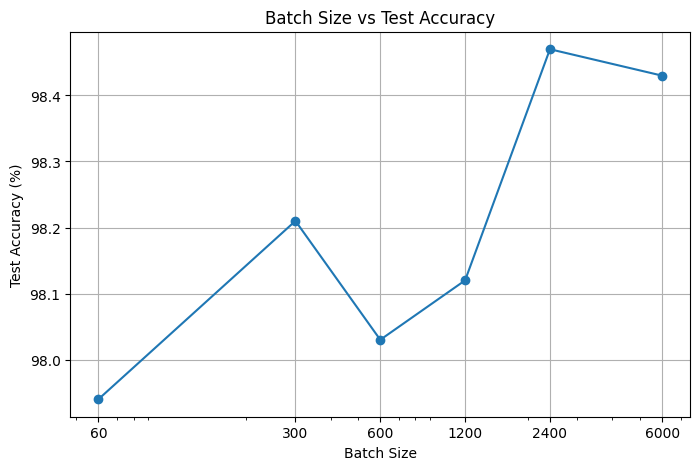


✅ Optimal Batch Size: 2400 with Test Accuracy: 98.47%


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed architecture matching saved model (depth8.pt)
def build_depth8_model():
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),      # 0
        nn.BatchNorm2d(16),                              # 1
        nn.ReLU(),                                       # 2

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 3
        nn.BatchNorm2d(16),                              # 4
        nn.ReLU(),                                       # 5

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 6
        nn.BatchNorm2d(16),                              # 7
        nn.ReLU(),                                       # 8

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 9
        nn.BatchNorm2d(16),                              # 10
        nn.ReLU(),                                       # 11

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 12
        nn.BatchNorm2d(16),                              # 13
        nn.ReLU(),                                       # 14

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 15
        nn.BatchNorm2d(16),                              # 16
        nn.ReLU(),                                       # 17

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 18
        nn.BatchNorm2d(16),                              # 19
        nn.ReLU(),                                       # 20

        nn.Conv2d(16, 16, kernel_size=3, padding=1),     # 21
        nn.BatchNorm2d(16),                              # 22
        nn.ReLU(),                                       # 23

        nn.Flatten(),                                    # 24
        nn.Linear(16 * 28 * 28, 10)                      # 25
    )


# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0.0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Datasets and transforms
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define training and evaluation functions
def train(model, train_loader, optimizer, criterion, val_loader, max_epochs=50, patience=2):
    early_stopper = EarlyStopping(patience=patience)
    for epoch in range(max_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        val_acc = evaluate(model, val_loader)
        if early_stopper(val_acc):
            break

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Load test data (fixed)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Batch sizes and results
batch_percentages = [0.001, 0.005, 0.01, 0.02, 0.04, 0.10]
batch_sizes = [int(60000 * p) for p in batch_percentages]
accuracies = []

# Path to pretrained model
model_path = "/content/drive/MyDrive/mnist_deepcnn/depth8.pt"

for bsz in batch_sizes:
    print(f"\nTraining with batch size {bsz} ({100*bsz/60000:.1f}%)...")

    # Subset of training data to use as batch-sized batches
    indices = np.random.permutation(len(train_dataset))[:bsz]
    train_subset = Subset(train_dataset, indices)
    train_loader = DataLoader(train_subset, batch_size=bsz, shuffle=True)

    # Validation split (20% of current batch)
    val_size = int(0.2 * bsz)
    val_indices = np.random.choice(indices, val_size, replace=False)
    val_subset = Subset(train_dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=bsz, shuffle=False)

    # Load and fine-tune model
    model = build_depth8_model().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, optimizer, criterion, val_loader, max_epochs=50, patience=5)
    acc = evaluate(model, test_loader)
    accuracies.append(acc)
    print(f"Test Accuracy: {acc:.2f}%")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, accuracies, marker='o')
plt.title("Batch Size vs Test Accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.xscale("log")
plt.xticks(batch_sizes, batch_sizes)
plt.show()

# Report best
best_idx = np.argmax(accuracies)
print(f"\n✅ Optimal Batch Size: {batch_sizes[best_idx]} with Test Accuracy: {accuracies[best_idx]:.2f}%")


In [35]:
import torch

# Load the saved model (without building a new architecture)
model_path = "/content/drive/MyDrive/mnist_deepcnn/depth8.pt"
state_dict = torch.load(model_path, map_location="cpu")

# Print all layer names in the state_dict
print("📦 Saved state_dict keys:")
for key in state_dict.keys():
    print(key)

# Print total number of layers
print(f"\nTotal layers in saved model: {len(state_dict)}")


📦 Saved state_dict keys:
0.weight
0.bias
1.weight
1.bias
1.running_mean
1.running_var
1.num_batches_tracked
3.weight
3.bias
4.weight
4.bias
4.running_mean
4.running_var
4.num_batches_tracked
6.weight
6.bias
7.weight
7.bias
7.running_mean
7.running_var
7.num_batches_tracked
9.weight
9.bias
10.weight
10.bias
10.running_mean
10.running_var
10.num_batches_tracked
12.weight
12.bias
13.weight
13.bias
13.running_mean
13.running_var
13.num_batches_tracked
15.weight
15.bias
16.weight
16.bias
16.running_mean
16.running_var
16.num_batches_tracked
18.weight
18.bias
19.weight
19.bias
19.running_mean
19.running_var
19.num_batches_tracked
21.weight
21.bias
22.weight
22.bias
22.running_mean
22.running_var
22.num_batches_tracked
25.weight
25.bias

Total layers in saved model: 58
